In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d
from cmocean import cm
import xscale as xsc

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(4*14)

# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.147:44047 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 56 Cores: 56 Memory: 959.84 GB


_________
# 1. Read LLC4320 output


In [4]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')
ds = xr.merge([ds_U,ds_V,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    ...       ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V        (time, depth, lat_g, lon) float32 das

In [5]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center


## Different filters

In [6]:
# define 4-th order butterworth filter 
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

cut = 1/5/24/3600    # 5 days 
fs = 1/3600
nyq = 0.5*fs
cut_5d = cut/nyq

b, a = butter(4, cut_5d , 'low')

In [7]:
# define gaussian filter 
def gaussianfilter(x, sigma, axis):
    
    return xr.apply_ufunc(gaussian_filter1d, x, sigma, axis,
                          dask='parallelized',
                          output_dtypes=[x.dtype])

In [9]:
# butterworth filter
ds_U_butter_filter = butter_filter(ds.U.isel(depth=10), b, a)

# gaussian filter
ds_U_gaussian_filter = gaussianfilter(ds.U.isel(depth=10), sigma=5*24/4, axis=0) # 5 days

# convolution filter (using xscale package)
wt_U = ds['U'].isel(depth=10).window
wt_U.set(n={'time': 5*24}, window={'time':'hanning'}, chunks = {'lat':1, 'lon_g':177,'time': 9415}) # 5 days
ds_U_conv_filter = wt_U.convolve()

(-0.5, 0.5)

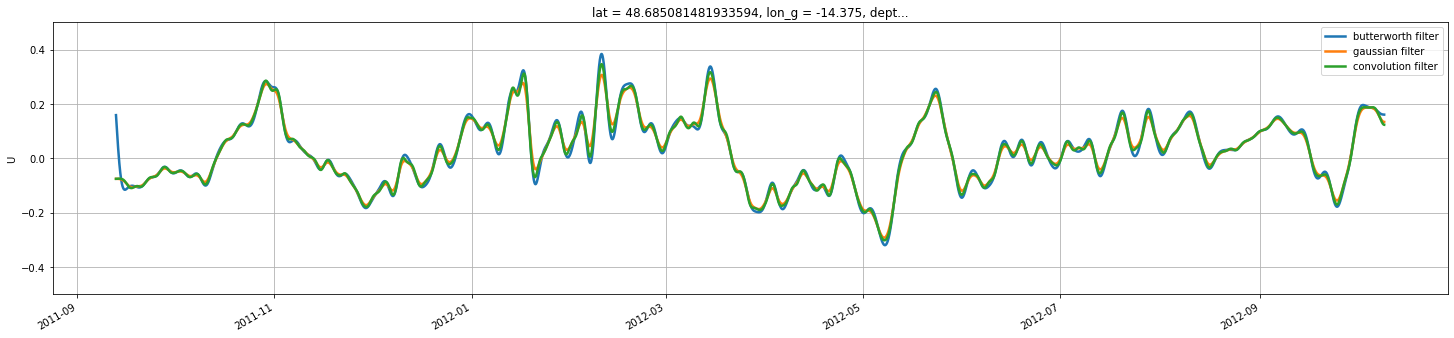

In [14]:
fig, ax = plt.subplots(figsize=(25,5))
ax = plt.subplot(111)

labels = ['butterworth filter','gaussian filter','convolution filter']

ds_U_butter_filter.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot(linewidth=2.5, label=labels[0])
ds_U_gaussian_filter.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot(linewidth=2.5, label=labels[1])
ds_U_conv_filter.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot(linewidth=2.5, label=labels[2])
ax.grid()
ax.legend(); 
ax.set_xlabel('')
ax.set_ylim([-.5, 0.5])

________
# 2. Calculate $\Pi_\omega$ using the Coarse-graining method

In [8]:
cut = 1/5/24/3600    # 5 days 
fs = 1/3600
nyq = 0.5*fs
cut_5d = cut/nyq

b, a = butter(4, cut_5d , 'low')

In [25]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
depth_all = range(52)

In [27]:
# works better with a few workers but a lot of memories
VV = ['PI_cg_5d_butter']

for depth in depth_all:
    
    for vv in VV:
        
        
        ds_U_filter = butter_filter(ds.U.isel(depth=depth), b, a)
        ds_V_filter = butter_filter(ds.V.isel(depth=depth), b, a)
        ds_U2_filter = butter_filter(ds['U'].isel(depth=depth)**2, b, a)
        ds_V2_filter = butter_filter(ds['V'].isel(depth=depth)**2, b, a)
        ds_UV_filter = butter_filter(gridx.interp(ds.V.isel(depth=depth),'Y')*gridx.interp(ds.U.isel(depth=depth),'X'), b, a)

        # f stands for low-pass filter
        du_dx = gridx.diff(ds_U_filter, 'X')/gridx.interp(ds.dxG, 'Y')
        dv_dy = gridx.diff(ds_V_filter, 'Y')/gridx.interp(ds.dyG, 'X')
        du_dy = gridx.interp(gridx.interp(gridx.diff(ds_U_filter, 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
        dv_dx = gridx.interp(gridx.interp(gridx.diff(ds_V_filter, 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

        PI_1 = (gridx.interp(ds_U2_filter, 'X')-gridx.interp(ds_U_filter**2, 'X'))*du_dx  # [f(u^2) - f(u)^2]*f(du/dx)
        PI_2 = (gridx.interp(ds_V2_filter, 'Y')-gridx.interp(ds_V_filter**2, 'Y'))*dv_dy  # [f(v^2) - f(v)^2]*f(dv/dy)
        PI_3 = (ds_UV_filter - gridx.interp(ds_U_filter,'X')*gridx.interp(ds_V_filter,'Y') )*(du_dy+dv_dx) # [f(uv) - f(u)f(v)]*[f(du/dy) + f(dv/dx)]

        PI_cg = -(PI_1+PI_2+PI_3)
        
        PI_cg_1d_single = PI_cg
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_1d_single = PI_cg_1d_single.chunk(chunks)
        PI_cg_1d_single = np.real(PI_cg_1d_single).rename('PI_cg_5d_butter')     
        PI_cg_1d_single = PI_cg_1d_single.to_dataset()
        
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_1d_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [30]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_gaussian/'

# takes about 25 mins
sigma_1d = 5*24/4 # 5 days

VV = ['PI_cg_5d_gaussian']

for depth in depth_all:
    
    for vv in VV:
        
        ds_U_filter = gaussianfilter(ds['U'].isel(depth=depth), sigma=sigma_1d, axis=0)
        ds_V_filter = gaussianfilter(ds['V'].isel(depth=depth), sigma=sigma_1d, axis=0)
        ds_U2_filter = gaussianfilter(ds['U'].isel(depth=depth)**2, sigma=sigma_1d, axis=0)
        ds_V2_filter = gaussianfilter(ds['V'].isel(depth=depth)**2, sigma=sigma_1d, axis=0)
        ds_UV_filter = gaussianfilter(gridx.interp(ds['V'].isel(depth=depth),'Y')*gridx.interp(ds['U'].isel(depth=depth),'X'), sigma=sigma_1d, axis=0)
        
        # f stands for low-pass filter
        du_dx = gridx.diff(ds_U_filter, 'X')/gridx.interp(ds.dxG, 'Y')
        dv_dy = gridx.diff(ds_V_filter, 'Y')/gridx.interp(ds.dyG, 'X')
        du_dy = gridx.interp(gridx.interp(gridx.diff(ds_U_filter, 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
        dv_dx = gridx.interp(gridx.interp(gridx.diff(ds_V_filter, 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

        PI_1 = (gridx.interp(ds_U2_filter, 'X')-gridx.interp(ds_U_filter**2, 'X'))*du_dx  # [f(u^2) - f(u)^2]*f(du/dx)
        PI_2 = (gridx.interp(ds_V2_filter, 'Y')-gridx.interp(ds_V_filter**2, 'Y'))*dv_dy  # [f(v^2) - f(v)^2]*f(dv/dy)
        PI_3 = (ds_UV_filter - gridx.interp(ds_U_filter,'X')*gridx.interp(ds_V_filter,'Y') )*(du_dy+dv_dx) # [f(uv) - f(u)f(v)]*[f(du/dy) + f(dv/dx)]
        PI_cg = -(PI_1+PI_2+PI_3)
   
        # the submesoscale band and save
        PI_cg_single = PI_cg
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_5d_gaussian')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

___________
# 3. Read results

In [15]:
# Butterworth
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_butter_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.assign_coords(depth=ds.depth) 
PI_cg_5d_butter = PI_cg_5d.PI_cg_5d_butter
print(PI_cg_5d_butter)

<xarray.DataArray 'PI_cg_5d_butter' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3


In [16]:
# Gaussian
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_gaussian/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_gaussian_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.assign_coords(depth=ds.depth) 
PI_cg_5d_gaussian = PI_cg_5d.PI_cg_5d_gaussian
print(PI_cg_5d_gaussian)

<xarray.DataArray 'PI_cg_5d_gaussian' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3


In [17]:
# Convolution filter
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg = xr.concat(D, dim='depth')
PI_cg = PI_cg.assign_coords(depth=ds.depth) 
PI_cg_5d_conv = PI_cg.PI_cg_single
PI_cg_5d_conv = np.real(PI_cg_5d_conv).rename('PI_cg_5d_conv')    
print(PI_cg_5d_conv)

<xarray.DataArray 'PI_cg_5d_conv' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<real, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3


In [18]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir_work+'mld_filter.zarr')

ds_PI = xr.merge([PI_cg_5d_butter,PI_cg_5d_gaussian,PI_cg_5d_conv,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))

ds_PI = ds_PI.assign_coords(time=time_day) 
ds_PI

,Array,Chunk
Bytes,69.67 GB,6.67 MB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,69.67 GB,6.67 MB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


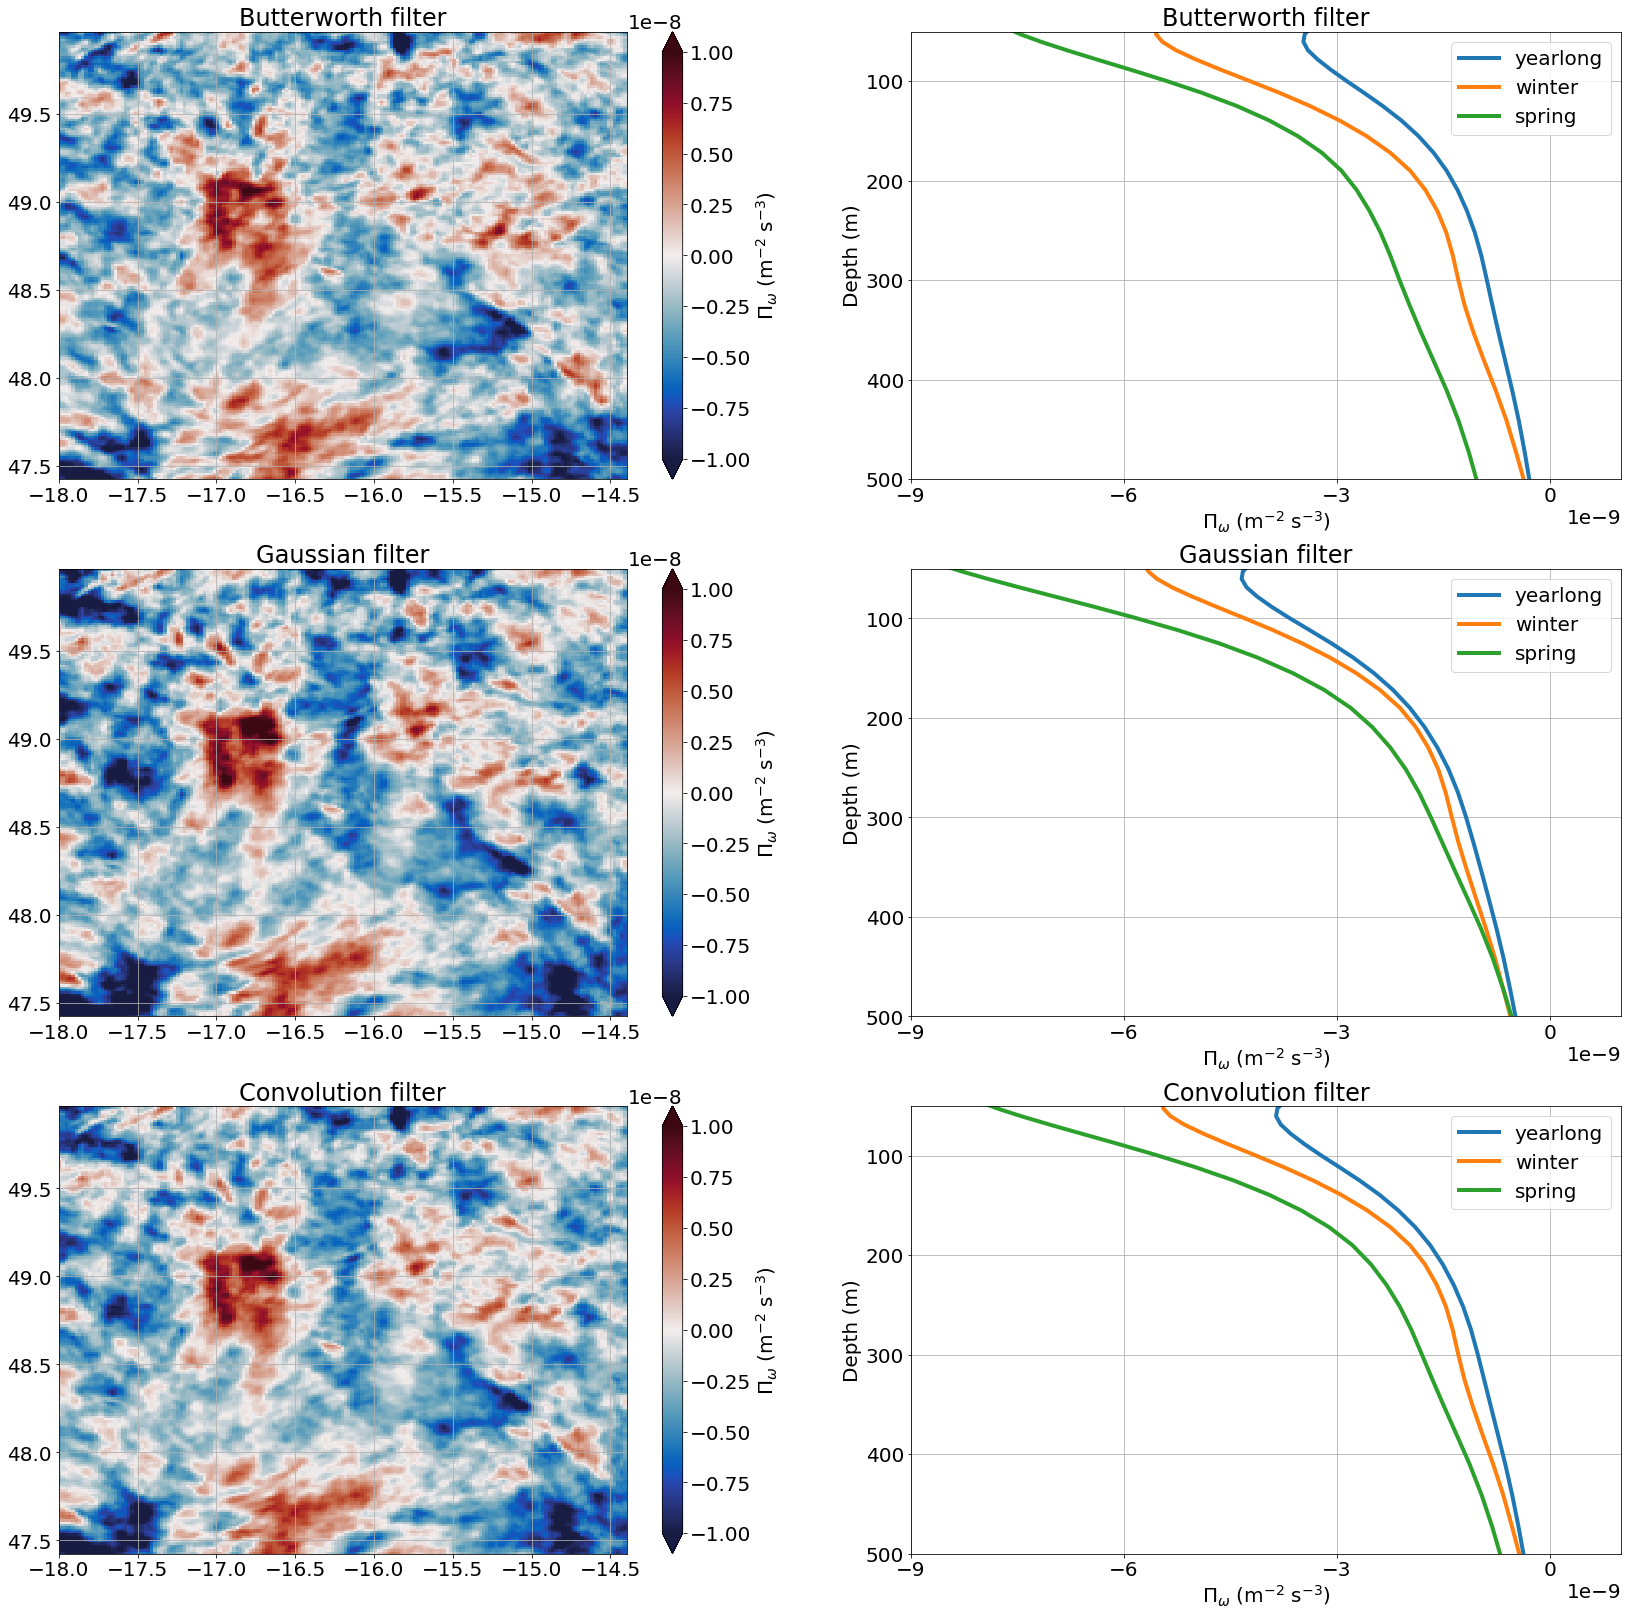

In [22]:
plt.rc('font', size=20) 
labels = ['yearlong','winter','spring']

font_size=20

fig, ax = plt.subplots(figsize=(28,28))
ax = plt.subplot(321)
cax = ds_PI.PI_cg_5d_butter.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Butterworth filter')

ax = plt.subplot(322)
ds_PI.PI_cg_5d_butter.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-09-20T00:00:00','2012-09-20T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[0])
ds_PI.PI_cg_5d_butter.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[1])
ds_PI.PI_cg_5d_butter.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[2])
ax.grid()
ax.legend(); 
ax.legend(prop={'size': font_size})
ax.set_xlim([-9e-9,1e-9])
ax.set_ylim([500., 50.])
ax.set_xticks([-9e-9, -6e-9,-3e-9, 0.])
ax.set_yticks([500,400,300,200,100])
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Butterworth filter')

ax = plt.subplot(323)
cax = ds_PI.PI_cg_5d_gaussian.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Gaussian filter')

ax = plt.subplot(324)
ds_PI.PI_cg_5d_gaussian.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-09-20T00:00:00','2012-09-20T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[0])
ds_PI.PI_cg_5d_gaussian.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[1])
ds_PI.PI_cg_5d_gaussian.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[2])
ax.grid()
ax.legend(); 
ax.legend(prop={'size': font_size})
ax.set_xlim([-9e-9,1e-9])
ax.set_ylim([500., 50.])
ax.set_xticks([-9e-9, -6e-9,-3e-9, 0.])
ax.set_yticks([500,400,300,200,100])
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Gaussian filter')

ax = plt.subplot(325)
cax = ds_PI.PI_cg_5d_conv.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Convolution filter')

ax = plt.subplot(326)
ds_PI.PI_cg_5d_conv.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-09-20T00:00:00','2012-09-20T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[0])
ds_PI.PI_cg_5d_conv.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[1])
ds_PI.PI_cg_5d_conv.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[2])
ax.grid()
ax.legend(); 
ax.legend(prop={'size': font_size})
ax.set_xlim([-9e-9,1e-9])
ax.set_ylim([500., 50.])
ax.set_xticks([-9e-9, -6e-9,-3e-9, 0.])
ax.set_yticks([500,400,300,200,100])
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Convolution filter')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/KE_flux_different_filters_1.png')

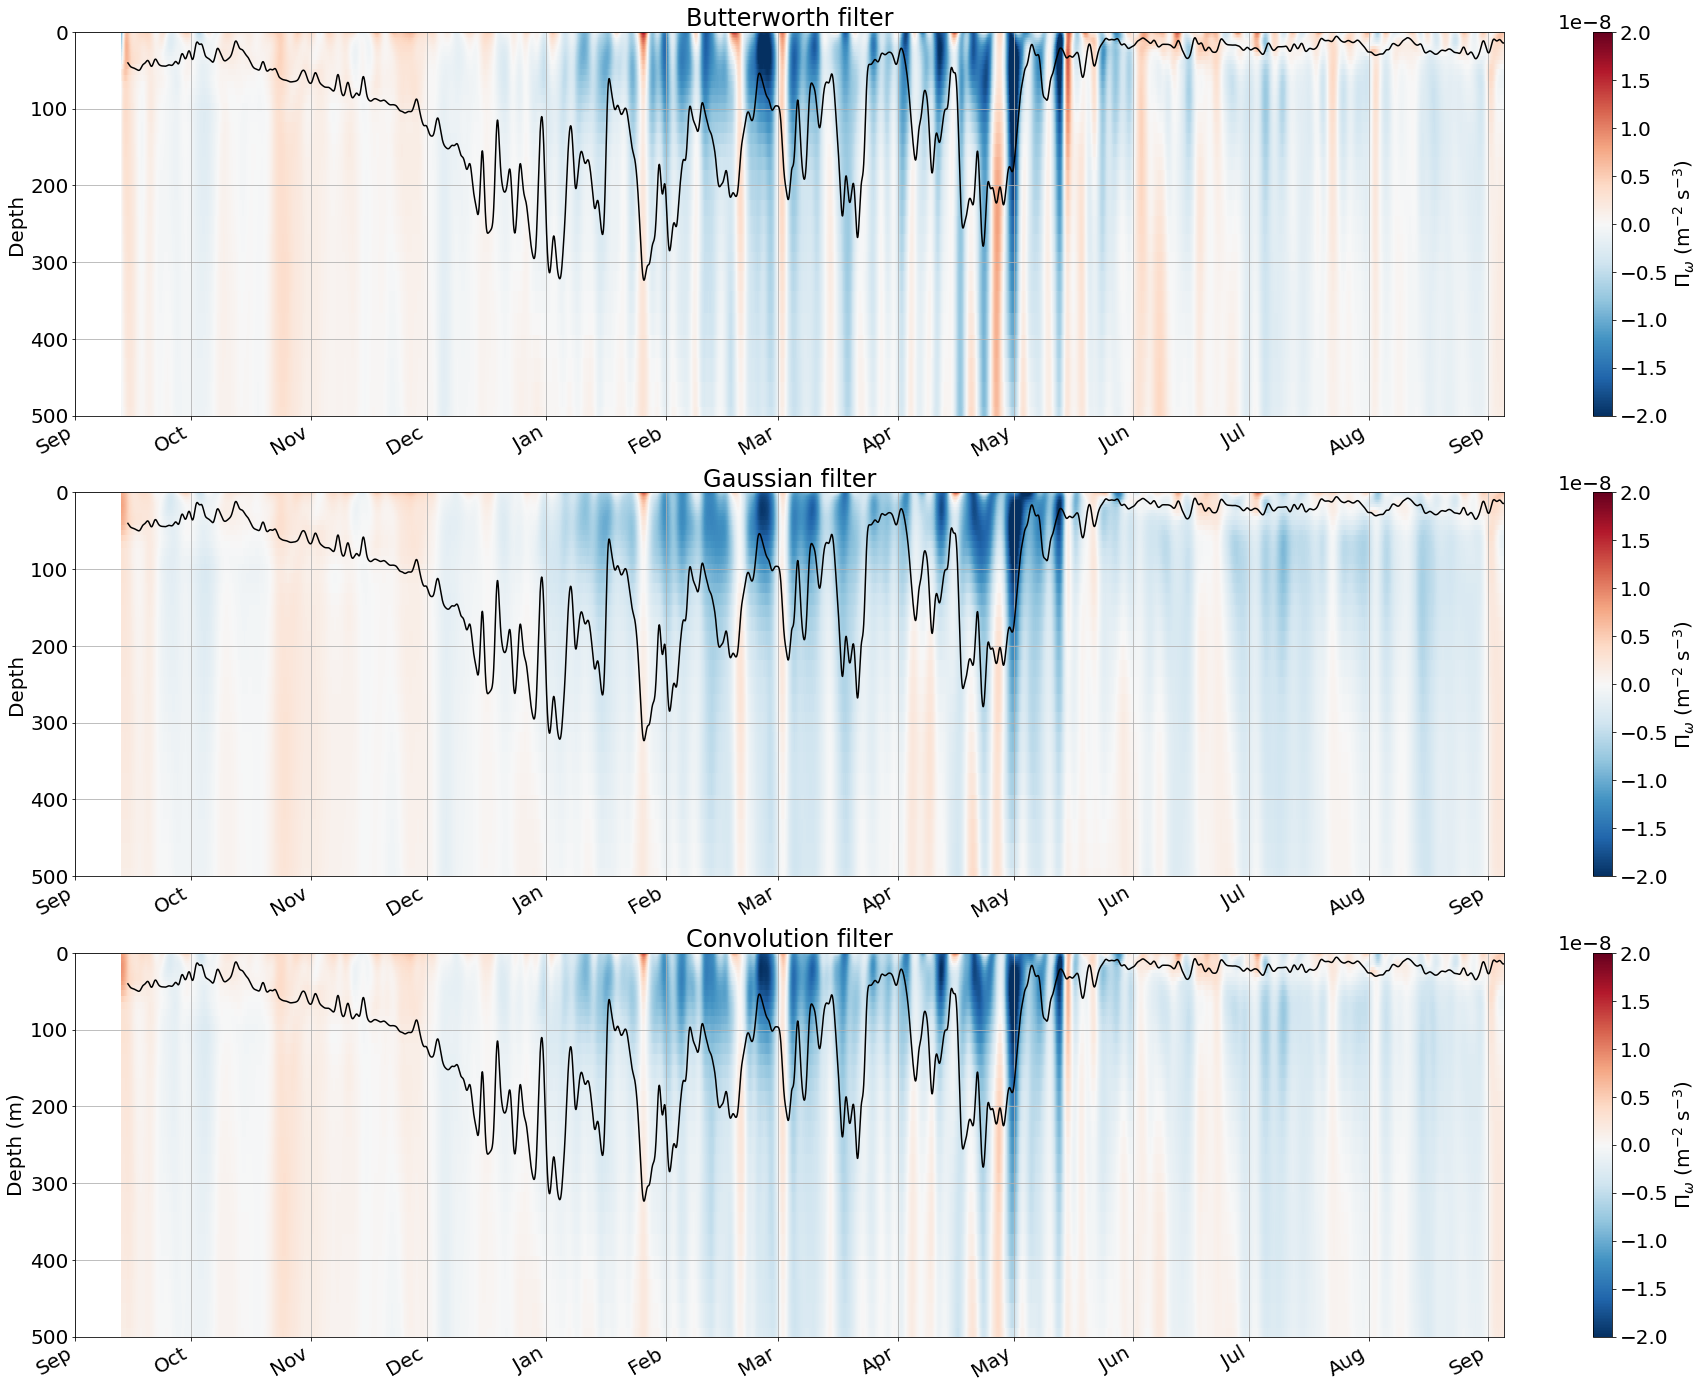

In [36]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(32,24))

ax = plt.subplot(311)
cax = ds_PI.PI_cg_5d_butter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_PI.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.set_title('Butterworth filter')

ax = plt.subplot(312)
cax = ds_PI.PI_cg_5d_gaussian.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_PI.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.set_title('Gaussian filter')

ax = plt.subplot(313)
cax = ds_PI.PI_cg_5d_conv.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_PI.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.set_title('Convolution filter')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/KE_flux_different_filters_2.png')

In [24]:
cluster.close()